<a href="https://colab.research.google.com/github/Katapkoon/office31-classification-model/blob/main/mobileDA_miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

by 65010101,65010869,65010902

#Pre-processing data

##import modules

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os
import tempfile
import random
from functools import partial
from pathlib import Path
%matplotlib inline

!pip install ray
import ray
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

##Define hyper-parameter

In [ ]:
# Hyper-parameter and setting
image_size = 224
batch_size = 32
channel_size = 3
base_lr = 1e-2
num_classes = 31
num_epochs_teacher = 15
num_epochs_student = 30

#    DOMAINS= = ["amazon", "dslr", "webcam"]
SOURCE_DOMAIN = "dslr"
TARGET_DOMAIN = "amazon"

##Train-test split

In [ ]:

# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device count : {torch.cuda.device_count()}')
# Data pre-processing of source and target domain
tf_source = transform.Compose([
    transform.Resize(image_size),
    transform.RandomApply(torch.nn.ModuleList([
    transform.RandomInvert(),
        transform.RandomRotation((-45, 45), center=(112, 112)),
        transform.RandomHorizontalFlip(),
        transform.RandomVerticalFlip(),
        transform.RandomGrayscale(),
        transform.RandomEqualize(),
 ]), p=0.5),
    transform.ToTensor(),
    transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# data_augmentation = transforms.Compose([
#         transforms.RandomEqualize(p=0.25),
#         transforms.Resize((224, 224)),
#         transforms.ColorJitter(brightness=(0.75,1.25),contrast=(1),saturation=(0.5,1.5),hue=(-0.3,0.3)),
#         transforms.RandomInvert(p=0.5),
#         transforms.RandomRotation((-45, 45), center=(112, 112)),
#         transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomVerticalFlip(p=0.5),
#         transforms.RandomGrayscale(p=0.25),
#         transforms.ToTensor(),
#     ])


tf_target = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

########################################################################################
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Dataset and dataloader source & target domain (train_set)

from google.colab import drive
drive.mount('./drive/')
!unzip -u './drive/MyDrive/Office-31.zip'

#---------------------------------TARGET------------------------

Ds_target = datasets.ImageFolder(root=f'/content/Office-31/{TARGET_DOMAIN}', transform=tf_target)
Dl_target = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)
train_split = 0.8
train_size = int(train_split * len(Ds_target))
test_size = len(Ds_target) - train_size
Dl_tar_training_set, Dl_tar_testing_set = torch.utils.data.random_split(Ds_target, [train_size, test_size])

Dl_tar_training_set_batch = DataLoader(Dl_tar_training_set, batch_size, shuffle=True, num_workers=2)
Dl_tar_testing_set_batch = DataLoader(Dl_tar_testing_set, batch_size, shuffle=False, num_workers=2)

#---------------------------------SOURCE---------------------------------------------
Ds_source = datasets.ImageFolder(root=f'/content/Office-31/{SOURCE_DOMAIN}', transform=tf_source)
Dl_source = DataLoader(Ds_source, batch_size, shuffle=True, num_workers=2)
st_train_split = 0.8
st_train_size = int(st_train_split * len(Ds_source))
st_test_size = len(Ds_source) - st_train_size
Dl_src_training_set, Dl_src_testing_set = torch.utils.data.random_split(Ds_source, [st_train_size, st_test_size])

Dl_src_training_set_batch = DataLoader(Dl_src_training_set, batch_size, shuffle=True, num_workers=2)
Dl_src_testing_set_batch = DataLoader(Dl_src_testing_set, batch_size, shuffle=False, num_workers=2)






device count : 1
Drive already mounted at ./drive/; to attempt to forcibly remount, call drive.mount("./drive/", force_remount=True).
Archive:  ./drive/MyDrive/Office-31.zip


#Data Visualization functions

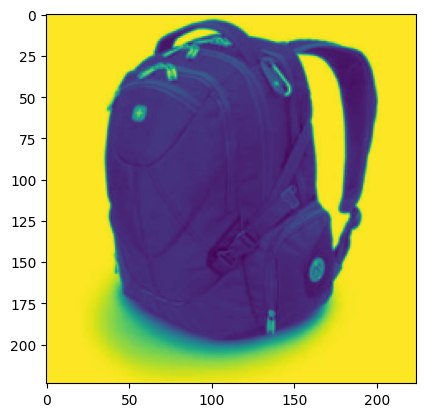

In [ ]:
#@title Function Plot graph
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_src_acc"], label="Train_src_acc")
    ax1.plot(history["train_tar_acc"], label="Train_tar_acc")
    ax1.legend()
    ax1.set_title("Accuracy (Src/Tar)")

    ax2.plot(history["train_loss"], label="Train_loss")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

    # Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# source
dataiter_src = iter(Dl_tar_training_set.dataset)
img_src, lbl_src = next(dataiter_src)
# target
dataiter_tar = iter(Dl_tar_testing_set.dataset)
img_tar, lbl_tar = next(dataiter_tar)

# Create a grid from the images and show them
img_src_grid = torchvision.utils.make_grid(img_src)
matplotlib_imshow(img_src_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))

In [ ]:
#@title plot teacher
def plot_graph_teacher(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

    # import os
    # if not os.path.exists('./plot-figures/'):
    #   os.makedirs('./plot-figures/')
    # fig.savefig(filename)

#CORAL,DistillKL

##CORAL

In [ ]:
class CorrelationAlignmentLoss(nn.Module):
    r"""The `Correlation Alignment Loss` in
    `Baochen Sun et al., Deep CORAL: Correlation Alignment for Deep Domain Adaptation (ECCV 2016) <https://arxiv.org/pdf/1607.01719.pdf>`_.
    Given source features :math:`f_S` and target features :math:`f_T`, the covariance matrices are given by
    .. math::
        C_S = \frac{1}{n_S-1}(f_S^Tf_S-\frac{1}{n_S}(\textbf{1}^Tf_S)^T(\textbf{1}^Tf_S))
    .. math::
        C_T = \frac{1}{n_T-1}(f_T^Tf_T-\frac{1}{n_T}(\textbf{1}^Tf_T)^T(\textbf{1}^Tf_T))
    where :math:`\textbf{1}` denotes a column vector with all elements equal to 1, :math:`n_S, n_T` denotes number of
    source and target samples, respectively. We use :math:`d` to denote feature dimension, use
    :math:`{\Vert\cdot\Vert}^2_F` to denote the squared matrix `Frobenius norm`. The correlation alignment loss is
    given by
    .. math::
        l_{CORAL} = \frac{1}{4d^2}\Vert C_S-C_T \Vert^2_F
    Inputs:
        - f_s (tensor): feature representations on source domain, :math:`f^s`
        - f_t (tensor): feature representations on target domain, :math:`f^t`
    Shape:
        - f_s, f_t: :math:`(N, d)` where d means the dimension of input features, :math:`N=n_S=n_T` is mini-batch size.
        - Outputs: scalar.
    """

    def __init__(self):
        super(CorrelationAlignmentLoss, self).__init__()

    def forward(self, f_s: torch.Tensor, f_t: torch.Tensor) -> torch.Tensor:
        mean_s = f_s.mean(0, keepdim=True)
        mean_t = f_t.mean(0, keepdim=True)
        cent_s = f_s - mean_s
        cent_t = f_t - mean_t
        cov_s = torch.mm(cent_s.t(), cent_s) / (len(f_s) - 1)
        cov_t = torch.mm(cent_t.t(), cent_t) / (len(f_t) - 1)

        mean_diff = (mean_s - mean_t).pow(2).mean()
        cov_diff = (cov_s - cov_t).pow(2).mean()

        return mean_diff + cov_diff

##DistillKL

In [ ]:
class DistillKL(nn.Module):
    """
      Arg:
      Distilling the Knowledge in a Neural Network
    """
    def __init__(self, Temperature,threshold):
        super(DistillKL, self).__init__()
        self.Temperature = Temperature
        self.threshold = threshold

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.Temperature, dim=1)
        #p_s = F.softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.Temperature, dim=1)
        # print(y_t)
        # print(p_t)
        # print(f'p_t : {p_t}')
        # print(f'p_t max : {p_t.max()}')
        # print(f'zeros {torch.zeros(1)}')
        # loss = F.kl_div(p_s, p_t, reduction='sum') * (self.Temperature**2) / y_s.shape[0]
        # print(loss)
        confidence_score = F.softmax(y_t, dim=1)
        # print(f'confidence_score : {confidence_score.max()}')
        # print(F.kl_div(p_s, p_t, reduction='sum') * (self.Temperature**2) / y_s.shape[0])
        if confidence_score.max() > self.threshold:
          loss = F.kl_div(p_s, p_t, reduction='sum') * (self.Temperature**2) / y_s.shape[0]
        else:
          loss = torch.zeros([])
        return loss


#CustomLRScheduler

In [ ]:
class CustomLRScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, num_epochs, last_epoch=-1):
        self.num_epochs = num_epochs
        self.current_round = 0
        super(CustomLRScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # Calculate 'p', which linearly changes from 0 to 1 over the epochs
        p = self.current_round / self.num_epochs

        print(f"GET LR  P : {p}")
        self.current_round += 1

        # lr_1 = optimizer.param_groups[0]['lr']
        # lr_2 = optimizer.param_groups[1]['lr']

        l2 = 0.01 / (1 + 10 * p) ** 0.75
        l1 = l2 / 10.0


        return [l1, l2]

#Training loop

##train teacher

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

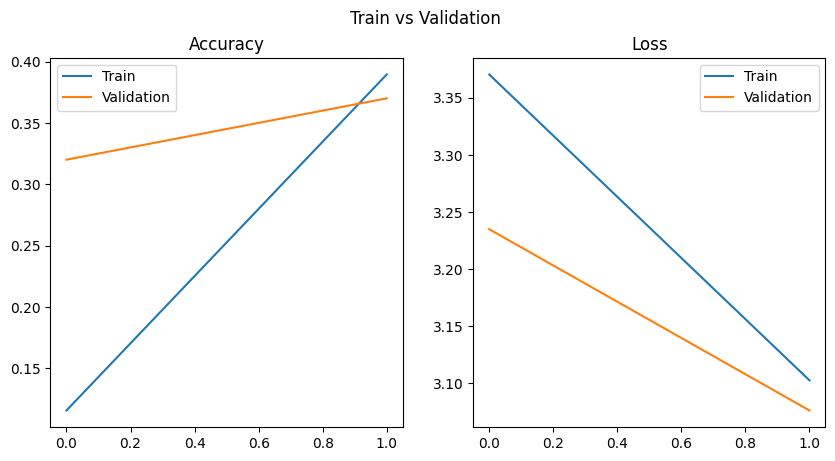

In [ ]:
teacher_fn = torchvision.models.mobilenet_v3_large(weights='IMAGENET1K_V1').to(device) #using mobilenet_v3_large from pytorch's torchvision
teacher_fn.classifier[0] = nn.Linear(in_features=960, out_features=1280, bias=True).to(device)
teacher_fn.classifier[3] = nn.Linear(in_features=1280, out_features=num_classes, bias=True).to(device)
summary(teacher_fn, input_size=(channel_size, image_size, image_size))
# Optimizer and cost function
# optimizer = optim.Adam(teacher_fn.parameters(), teacher_lr,weight_decay=1e-5)
# optimizer = optim.SGD(teacher_fn.parameters(), lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.SGD(
    [dict(params= teacher_fn.features.parameters(), lr=base_lr/10), # best at 1e-4
     dict(params= teacher_fn.classifier.parameters()),
      ],
    lr=base_lr,  # learning rate for all layers if none of any setting individual
    momentum=0.9,weight_decay=5e-4
    )

# scheduler_teacher = optim.lr_scheduler.LinearLR(optimizer, start_factor=1,end_factor=0.1,total_iters=num_epochs_teacher)
scheduler_teacher = CustomLRScheduler(optimizer, num_epochs_teacher)
# loss_fn = torch.nn.CrossEntropyLoss(
loss_fn = torch.nn.CrossEntropyLoss()
# Training the same number of batches from both datasets
# max_batches = min(len(Dl_source), len(Dl_target))
###########################################################################
# 1st step: Training teacher net
t_0 = time.time()
iter_teacher = 0
best_vloss = 1_000_000.
training_logs_teacher = {"train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}
for epoch_T in range(num_epochs_teacher):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch_T+1:04d} / {num_epochs_teacher:04d}', end='\n============\n')
    for i_T, data_T in enumerate(Dl_src_training_set_batch):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()
        # GPU processing source and target data
        X_T, y_T = data_T[0].to(device), data_T[1].to(device)
        yhat_T = teacher_fn(X_T)
        loss = loss_fn(yhat_T, y_T)                 # source classification loss
        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()
        # #output predict from net
        with torch.no_grad():
          class_prediction_T = teacher_fn(X_T)
        print(f'[{i_T+1}/{len(Dl_src_training_set_batch)}] '
              f'teacher class loss: {loss.item():.4f} '
              )



        train_loss += loss.item()
        train_correct += (class_prediction_T.argmax(1) == y_T).float().sum().item()
    training_logs_teacher["train_loss"].append(train_loss / len(Dl_src_training_set_batch))
    training_logs_teacher["train_acc"].append(train_correct / len(Dl_src_training_set_batch.dataset))#.dataset))
    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    teacher_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_src_testing_set_batch):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = teacher_fn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_teacher["val_loss"].append(valid_loss / len(Dl_src_testing_set_batch))
        training_logs_teacher["val_acc"].append(valid_correct / len(Dl_src_testing_set_batch.dataset))
    if epoch_T % 1 == 0:
        print(f"Epochs {epoch_T+1}".ljust(10),
            f"train loss {training_logs_teacher['train_loss'][-1]:.5f}",
            f"train acc {training_logs_teacher['train_acc'][-1]:.5f}",
            f"validate loss {training_logs_teacher['val_loss'][-1]:.5f}",
            f"validate acc {training_logs_teacher['val_acc'][-1]:.5f}",
            )
        print("-"*80)
    scheduler_teacher.step()
    if train_loss < best_vloss:

      best_vloss = train_loss
      path_save_cp = './cp/'
      if not os.path.exists(path_save_cp):
        os.mkdir(path_save_cp)
      torch.save(teacher_fn.state_dict(), path_save_cp+'best_teacher_model.pth')
    iter_teacher += 1
t_end = time.time()-t_0
print(f"Time consumption for teacher net (device:{device}): {t_end} sec")
plot_graph_teacher(training_logs_teacher)

# teacher inference

In [ ]:
# Inference phase

PATH = './cp/best_teacher_model.pth'

loaded_model = torchvision.models.mobilenet_v3_large(weights='IMAGENET1K_V1').to(device) #using mobilenet_v3_large from pytorch's torchvision
loaded_model.classifier[0] = nn.Linear(in_features=960, out_features=1280, bias=True).to(device)
loaded_model.classifier[3] = nn.Linear(in_features=1280, out_features=num_classes, bias=True).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
loaded_model.load_state_dict(torch.load(PATH))
test_loss = 0
loaded_model.to(device).eval()

stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32).to(device)
stored_lbs_tar = torch.empty(0, dtype=torch.float32)
stored_preds_tar = torch.empty(0, dtype=torch.float32)
Dl_src_testing_set_batch = torch.utils.data.DataLoader(Dl_src_testing_set, batch_size=64, shuffle=False)
acc_test = 0
for i, tdata in enumerate(Dl_src_testing_set_batch):
  with torch.no_grad():
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss.item()


    acc_test += (toutputs.argmax(1) == tlabels).float().sum().item()

    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)

    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

    stored_lbs_tar = torch.cat((stored_lbs_tar, tlabels.cpu()), 0)  # Move y_t to CPU for storage
    _, prediction_t = torch.max(toutputs, 1)
    stored_preds_tar = torch.cat((stored_preds_tar, prediction_t.cpu()), 0)


accuracy_t = acc_test / len(Dl_src_testing_set_batch.dataset)
avg_tloss = test_loss / len(Dl_src_testing_set_batch)
print('[(pretraining || test loss: {}] \t\t [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))



<ipython-input-10-775191d47c19>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH))


[(pretraining || test loss: 3.0937106609344482] 		 [accuracy_test: 34.0 %]


#student

In [ ]:
# @title FLOPS computation
# Code from https://github.com/Eric-mingjie/rethinking-network-pruning/blob/master/imagenet/l1-norm-pruning/compute_flops.py
import numpy as np
import os

import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable


def print_model_param_nums(model=None):
    if model == None:
        model = torchvision.models.alexnet()
    total = sum([param.nelement() if param.requires_grad else 0 for param in model.parameters()])
    print('  + Number of params: %.4fM' % (total / 1e6))

def count_model_param_flops(model=None, input_res=224, multiply_adds=True):

    prods = {}
    def save_hook(name):
        def hook_per(self, input, output):
            prods[name] = np.prod(input[0].shape)
        return hook_per

    list_1=[]
    def simple_hook(self, input, output):
        list_1.append(np.prod(input[0].shape))
    list_2={}
    def simple_hook2(self, input, output):
        list_2['names'] = np.prod(input[0].shape)


    list_conv=[]
    def conv_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size[0] * self.kernel_size[1] * (self.in_channels / self.groups)
        bias_ops = 1 if self.bias is not None else 0

        params = output_channels * (kernel_ops + bias_ops)
        # flops = (kernel_ops * (2 if multiply_adds else 1) + bias_ops) * output_channels * output_height * output_width * batch_size

        num_weight_params = (self.weight.data != 0).float().sum()
        flops = (num_weight_params * (2 if multiply_adds else 1) + bias_ops * output_channels) * output_height * output_width * batch_size

        list_conv.append(flops)

    list_linear=[]
    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1

        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()

        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    list_bn=[]
    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement() * 2)

    list_relu=[]
    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    list_pooling=[]
    def pooling_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size * self.kernel_size
        bias_ops = 0
        params = 0
        flops = (kernel_ops + bias_ops) * output_channels * output_height * output_width * batch_size

        list_pooling.append(flops)

    list_upsample=[]

    # For bilinear upsample
    def upsample_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        flops = output_height * output_width * output_channels * batch_size * 12
        list_upsample.append(flops)

    def foo(net):
        childrens = list(net.children())
        if not childrens:
            if isinstance(net, torch.nn.Conv2d):
                net.register_forward_hook(conv_hook)
            if isinstance(net, torch.nn.Linear):
                net.register_forward_hook(linear_hook)
            if isinstance(net, torch.nn.BatchNorm2d):
                net.register_forward_hook(bn_hook)
            if isinstance(net, torch.nn.ReLU):
                net.register_forward_hook(relu_hook)
            if isinstance(net, torch.nn.MaxPool2d) or isinstance(net, torch.nn.AvgPool2d):
                net.register_forward_hook(pooling_hook)
            if isinstance(net, torch.nn.Upsample):
                net.register_forward_hook(upsample_hook)
            return
        for c in childrens:
            foo(c)

    if model == None:
        model = torchvision.models.to.device()
    foo(model)
    input = Variable(torch.rand(3,input_res,input_res).unsqueeze(0), requires_grad = True).to(device)
    out = model(input)


    total_flops = (sum(list_conv) + sum(list_linear) + sum(list_bn) + sum(list_relu) + sum(list_pooling) + sum(list_upsample))

    print('Number of FLOPs: %.6f GFLOPs (%.2f MFLOPs)' % (total_flops / 1e9, total_flops / 1e6))

    return total_flops

In [ ]:
student_fn_globpruned = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1').to(device)
summary(student_fn_globpruned, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn_globpruned.eval())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

tensor(1.1632e+08, device='cuda:0')

##pruning student

In [ ]:
import copy
import torch.nn.utils.prune as prune
"""
So far, we only looked at what is usually referred to as “local” pruning, i.e.,
the practice of pruning tensors in a model one by one, by comparing the
statistics (weight magnitude, activation, gradient, etc.) of each entry
exclusively to the other entries in that tensor. However, a common and perhaps
more powerful technique is to prune the model all at once, by removing
(for example) the lowest 20% of connections across the whole model, instead of
removing the lowest 20% of connections in each layer. This is likely to result
in different pruning percentages per layer. Let’s see how to do that using
global_unstructured from 'torch.nn.utils.prune.'
"""
def pruned_student_model(l1):
  student_fn_globpruned = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1').to(device)
  student_fn_globpruned.classifier[0] = nn.Linear(in_features=576, out_features=l1, bias=True).to(device)
  student_fn_globpruned.classifier[3] = nn.Linear(in_features=l1, out_features=31, bias=True).to(device)
  f_allpruned = student_fn_globpruned.features
  C_allpruned = student_fn_globpruned.classifier
  # print(f_allpruned[4])
  parameters_to_prune = (
      (f_allpruned[0][0], 'weight'),
      (f_allpruned[1].block[0][0], 'weight'),
      (f_allpruned[1].block[2][0], 'weight'),
      (f_allpruned[2].block[0][0], 'weight'),
      (f_allpruned[2].block[1][0], 'weight'),
      (f_allpruned[2].block[2][0], 'weight'),
      (f_allpruned[3].block[0][0], 'weight'),
      (f_allpruned[3].block[1][0], 'weight'),
      (f_allpruned[3].block[2][0], 'weight'),
      (f_allpruned[4].block[0][0], 'weight'),
      (f_allpruned[4].block[1][0], 'weight'),
      (f_allpruned[4].block[3][0], 'weight'),
      (f_allpruned[5].block[0][0], 'weight'),
      (f_allpruned[5].block[1][0], 'weight'),
      (f_allpruned[5].block[3][0], 'weight'),
      (f_allpruned[6].block[0][0], 'weight'),
      (f_allpruned[6].block[1][0], 'weight'),
      (f_allpruned[6].block[3][0], 'weight'),
      (f_allpruned[7].block[0][0], 'weight'),
      (f_allpruned[7].block[1][0], 'weight'),
      (f_allpruned[7].block[3][0], 'weight'),
      (f_allpruned[8].block[0][0], 'weight'),
      (f_allpruned[8].block[1][0], 'weight'),
      (f_allpruned[8].block[3][0], 'weight'),
      (f_allpruned[9].block[0][0], 'weight'),
      (f_allpruned[9].block[1][0], 'weight'),
      (f_allpruned[9].block[3][0], 'weight'),
      (f_allpruned[10].block[0][0], 'weight'),
      (f_allpruned[10].block[1][0], 'weight'),
      (f_allpruned[10].block[3][0], 'weight'),
      (f_allpruned[11].block[0][0], 'weight'),
      (f_allpruned[11].block[1][0], 'weight'),
      (f_allpruned[11].block[3][0], 'weight'),
      (f_allpruned[12][0], 'weight'),
      (f_allpruned[1].block[1].fc1, 'weight'),
      (f_allpruned[1].block[1].fc2, 'weight'),
      (f_allpruned[4].block[2].fc1, 'weight'),
      (f_allpruned[4].block[2].fc2, 'weight'),
      (f_allpruned[5].block[2].fc1, 'weight'),
      (f_allpruned[5].block[2].fc2, 'weight'),
      (f_allpruned[6].block[2].fc1, 'weight'),
      (f_allpruned[6].block[2].fc2, 'weight'),
      (f_allpruned[7].block[2].fc1, 'weight'),
      (f_allpruned[7].block[2].fc2, 'weight'),
      (f_allpruned[8].block[2].fc1, 'weight'),
      (f_allpruned[8].block[2].fc2, 'weight'),
      (f_allpruned[9].block[2].fc1, 'weight'),
      (f_allpruned[9].block[2].fc2, 'weight'),
      (f_allpruned[10].block[2].fc1, 'weight'),
      (f_allpruned[10].block[2].fc2, 'weight'),
      (f_allpruned[11].block[2].fc1, 'weight'),
      (f_allpruned[11].block[2].fc2, 'weight'),
      # (C_allpruned, 'weight'),
  )

  # Pruning the same setting
  prune.global_unstructured(
      parameters_to_prune,
      pruning_method=prune.L1Unstructured,
      amount=0.3,
  )



  # --- example: in case of self.layer
  print(
      "Sparsity in f_allpruned[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[0][0].weight == 0))
          / float(f_allpruned[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[1].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[1].block[0][0].weight == 0))
          / float(f_allpruned[1].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[1].block[2][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[1].block[2][0].weight == 0))
          / float(f_allpruned[1].block[2][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[2].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[2].block[0][0].weight == 0))
          / float(f_allpruned[2].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[2].block[1][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[2].block[1][0].weight == 0))
          / float(f_allpruned[2].block[1][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[2].block[2][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[2].block[2][0].weight == 0))
          / float(f_allpruned[2].block[2][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[3].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[3].block[0][0].weight == 0))
          / float(f_allpruned[3].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[3].block[1][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[3].block[1][0].weight == 0))
          / float(f_allpruned[3].block[1][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[3].block[2][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[3].block[2][0].weight == 0))
          / float(f_allpruned[3].block[2][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[4].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[4].block[0][0].weight == 0))
          / float(f_allpruned[4].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[4].block[1][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[4].block[1][0].weight == 0))
          / float(f_allpruned[4].block[1][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[4].block[3][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[4].block[3][0].weight == 0))
          / float(f_allpruned[4].block[3][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[5].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[5].block[0][0].weight == 0))
          / float(f_allpruned[5].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[5].block[1][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[5].block[1][0].weight == 0))
          / float(f_allpruned[5].block[1][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[5].block[3][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[5].block[3][0].weight == 0))
          / float(f_allpruned[5].block[3][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[6].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[6].block[0][0].weight == 0))
          / float(f_allpruned[6].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[6].block[1][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[6].block[1][0].weight == 0))
          / float(f_allpruned[6].block[1][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[6].block[3][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[6].block[3][0].weight == 0))
          / float(f_allpruned[6].block[3][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[7].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[7].block[0][0].weight == 0))
          / float(f_allpruned[7].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[7].block[1][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[7].block[1][0].weight == 0))
          / float(f_allpruned[7].block[1][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[7].block[3][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[7].block[3][0].weight == 0))
          / float(f_allpruned[7].block[3][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[8].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[8].block[0][0].weight == 0))
          / float(f_allpruned[8].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[8].block[1][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[8].block[1][0].weight == 0))
          / float(f_allpruned[8].block[1][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[8].block[3][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[8].block[3][0].weight == 0))
          / float(f_allpruned[8].block[3][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[9].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[9].block[0][0].weight == 0))
          / float(f_allpruned[9].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[9].block[1][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[9].block[1][0].weight == 0))
          / float(f_allpruned[9].block[1][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[9].block[3][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[9].block[3][0].weight == 0))
          / float(f_allpruned[9].block[3][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[10].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[10].block[0][0].weight == 0))
          / float(f_allpruned[10].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[10].block[1][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[10].block[1][0].weight == 0))
          / float(f_allpruned[10].block[1][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[10].block[3][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[10].block[3][0].weight == 0))
          / float(f_allpruned[10].block[3][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[11].block[0][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[11].block[0][0].weight == 0))
          / float(f_allpruned[11].block[0][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[11].block[1][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[11].block[1][0].weight == 0))
          / float(f_allpruned[11].block[1][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[11].block[3][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[11].block[3][0].weight == 0))
          / float(f_allpruned[11].block[3][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[12][0].weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[12][0].weight == 0))
          / float(f_allpruned[12][0].weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[1].block[1].fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[1].block[1].fc1.weight == 0))
          / float(f_allpruned[1].block[1].fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[1].block[1].fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[1].block[1].fc2.weight == 0))
          / float(f_allpruned[1].block[1].fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[4].block[2].fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[4].block[2].fc1.weight == 0))
          / float(f_allpruned[4].block[2].fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[4].block[2].fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[4].block[2].fc2.weight == 0))
          / float(f_allpruned[4].block[2].fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[5].block[2].fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[5].block[2].fc1.weight == 0))
          / float(f_allpruned[5].block[2].fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[5].block[2].fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[5].block[2].fc2.weight == 0))
          / float(f_allpruned[5].block[2].fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[6].block[2].fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[6].block[2].fc1.weight == 0))
          / float(f_allpruned[6].block[2].fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[6].block[2].fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[6].block[2].fc2.weight == 0))
          / float(f_allpruned[6].block[2].fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[7].block[2].fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[7].block[2].fc1.weight == 0))
          / float(f_allpruned[7].block[2].fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[7].block[2].fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[7].block[2].fc2.weight == 0))
          / float(f_allpruned[7].block[2].fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[8].block[2].fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[8].block[2].fc1.weight == 0))
          / float(f_allpruned[8].block[2].fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[8].block[2].fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[8].block[2].fc2.weight == 0))
          / float(f_allpruned[8].block[2].fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[9].block[2].fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[9].block[2].fc1.weight == 0))
          / float(f_allpruned[9].block[2].fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[9].block[2].fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[9].block[2].fc2.weight == 0))
          / float(f_allpruned[9].block[2].fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[10].block[2].fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[10].block[2].fc1.weight == 0))
          / float(f_allpruned[10].block[2].fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[10].block[2].fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[10].block[2].fc2.weight == 0))
          / float(f_allpruned[10].block[2].fc2.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[11].block[2].fc1.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[11].block[2].fc1.weight == 0))
          / float(f_allpruned[11].block[2].fc1.weight.nelement())
      )
  )
  print(
      "Sparsity in f_allpruned[11].block[2].fc2.weight: {:.2f}%".format(
          100. * float(torch.sum(f_allpruned[11].block[2].fc2.weight == 0))
          / float(f_allpruned[11].block[2].fc2.weight.nelement())
      )
  )
  # print(
  #     "Sparsity in C_allpruned.weight: {:.2f}%".format(
  #         100. * float(torch.sum(C_allpruned.weight == 0))
  #         / float(C_allpruned.weight.nelement())
  #     )
  # )
  print(
      "Global sparsity: {:.2f}%".format(
          100. * float(
              torch.sum(f_allpruned[0][0].weight == 0)
              + torch.sum(f_allpruned[1].block[0][0].weight == 0)
              + torch.sum(f_allpruned[1].block[2][0].weight == 0)
              + torch.sum(f_allpruned[2].block[0][0].weight == 0)
              + torch.sum(f_allpruned[2].block[1][0].weight == 0)
              + torch.sum(f_allpruned[2].block[2][0].weight == 0)
              + torch.sum(f_allpruned[3].block[0][0].weight == 0)
              + torch.sum(f_allpruned[3].block[1][0].weight == 0)
              + torch.sum(f_allpruned[3].block[2][0].weight == 0)
              + torch.sum(f_allpruned[4].block[0][0].weight == 0)
              + torch.sum(f_allpruned[4].block[1][0].weight == 0)
              + torch.sum(f_allpruned[4].block[3][0].weight == 0)
              + torch.sum(f_allpruned[5].block[0][0].weight == 0)
              + torch.sum(f_allpruned[5].block[1][0].weight == 0)
              + torch.sum(f_allpruned[5].block[3][0].weight == 0)
              + torch.sum(f_allpruned[6].block[0][0].weight == 0)
              + torch.sum(f_allpruned[6].block[1][0].weight == 0)
              + torch.sum(f_allpruned[6].block[3][0].weight == 0)
              + torch.sum(f_allpruned[7].block[0][0].weight == 0)
              + torch.sum(f_allpruned[7].block[1][0].weight == 0)
              + torch.sum(f_allpruned[7].block[3][0].weight == 0)
              + torch.sum(f_allpruned[8].block[0][0].weight == 0)
              + torch.sum(f_allpruned[8].block[1][0].weight == 0)
              + torch.sum(f_allpruned[8].block[3][0].weight == 0)
              + torch.sum(f_allpruned[9].block[0][0].weight == 0)
              + torch.sum(f_allpruned[9].block[1][0].weight == 0)
              + torch.sum(f_allpruned[9].block[3][0].weight == 0)
              + torch.sum(f_allpruned[10].block[0][0].weight == 0)
              + torch.sum(f_allpruned[10].block[1][0].weight == 0)
              + torch.sum(f_allpruned[10].block[3][0].weight == 0)
              + torch.sum(f_allpruned[11].block[0][0].weight == 0)
              + torch.sum(f_allpruned[11].block[1][0].weight == 0)
              + torch.sum(f_allpruned[11].block[3][0].weight == 0)
              + torch.sum(f_allpruned[12][0].weight == 0)
              + torch.sum(f_allpruned[1].block[1].fc1.weight == 0)
              + torch.sum(f_allpruned[1].block[1].fc2.weight == 0)
              + torch.sum(f_allpruned[4].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[4].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[5].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[5].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[6].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[6].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[7].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[7].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[8].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[8].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[9].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[9].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[10].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[10].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[11].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[11].block[2].fc2.weight == 0)
              # + torch.sum(C_allpruned.weight == 0)
          )
          / float(
              torch.sum(f_allpruned[0][0].weight == 0)
              + torch.sum(f_allpruned[1].block[0][0].weight == 0)
              + torch.sum(f_allpruned[1].block[2][0].weight == 0)
              + torch.sum(f_allpruned[2].block[0][0].weight == 0)
              + torch.sum(f_allpruned[2].block[1][0].weight == 0)
              + torch.sum(f_allpruned[2].block[2][0].weight == 0)
              + torch.sum(f_allpruned[3].block[0][0].weight == 0)
              + torch.sum(f_allpruned[3].block[1][0].weight == 0)
              + torch.sum(f_allpruned[3].block[2][0].weight == 0)
              + torch.sum(f_allpruned[4].block[0][0].weight == 0)
              + torch.sum(f_allpruned[4].block[1][0].weight == 0)
              + torch.sum(f_allpruned[4].block[3][0].weight == 0)
              + torch.sum(f_allpruned[5].block[0][0].weight == 0)
              + torch.sum(f_allpruned[5].block[1][0].weight == 0)
              + torch.sum(f_allpruned[5].block[3][0].weight == 0)
              + torch.sum(f_allpruned[6].block[0][0].weight == 0)
              + torch.sum(f_allpruned[6].block[1][0].weight == 0)
              + torch.sum(f_allpruned[6].block[3][0].weight == 0)
              + torch.sum(f_allpruned[7].block[0][0].weight == 0)
              + torch.sum(f_allpruned[7].block[1][0].weight == 0)
              + torch.sum(f_allpruned[7].block[3][0].weight == 0)
              + torch.sum(f_allpruned[8].block[0][0].weight == 0)
              + torch.sum(f_allpruned[8].block[1][0].weight == 0)
              + torch.sum(f_allpruned[8].block[3][0].weight == 0)
              + torch.sum(f_allpruned[9].block[0][0].weight == 0)
              + torch.sum(f_allpruned[9].block[1][0].weight == 0)
              + torch.sum(f_allpruned[9].block[3][0].weight == 0)
              + torch.sum(f_allpruned[10].block[0][0].weight == 0)
              + torch.sum(f_allpruned[10].block[1][0].weight == 0)
              + torch.sum(f_allpruned[10].block[3][0].weight == 0)
              + torch.sum(f_allpruned[11].block[0][0].weight == 0)
              + torch.sum(f_allpruned[11].block[1][0].weight == 0)
              + torch.sum(f_allpruned[11].block[3][0].weight == 0)
              + torch.sum(f_allpruned[12][0].weight == 0)
              # + torch.sum(C_allpruned.weight == 0)
              + torch.sum(f_allpruned[1].block[1].fc1.weight == 0)
              + torch.sum(f_allpruned[1].block[1].fc2.weight == 0)
              + torch.sum(f_allpruned[4].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[4].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[5].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[5].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[6].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[6].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[7].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[7].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[8].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[8].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[9].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[9].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[10].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[10].block[2].fc2.weight == 0)
              + torch.sum(f_allpruned[11].block[2].fc1.weight == 0)
              + torch.sum(f_allpruned[11].block[2].fc2.weight == 0)
          )
      )
  )

  # student_fn_globpruned = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1').to(device)
  # student_fn_globpruned.features = f_allpruned.to(device)
  # student_fn_globpruned.classifier = C_allpruned.to(device)
  summary(student_fn_globpruned, input_size=(channel_size, image_size, image_size))
  count_model_param_flops(model=student_fn_globpruned.eval())
  return student_fn_globpruned

##train student

<ipython-input-14-6ccaf16ccd37>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  main_teacher_fn.load_state_dict(torch.load('/content/cp/best_teacher_model.pth'))


Sparsity in f_allpruned[0][0].weight: 14.35%
Sparsity in f_allpruned[1].block[0][0].weight: 9.72%
Sparsity in f_allpruned[1].block[2][0].weight: 19.14%
Sparsity in f_allpruned[2].block[0][0].weight: 21.27%
Sparsity in f_allpruned[2].block[1][0].weight: 15.43%
Sparsity in f_allpruned[2].block[2][0].weight: 23.55%
Sparsity in f_allpruned[3].block[0][0].weight: 36.36%
Sparsity in f_allpruned[3].block[1][0].weight: 33.96%
Sparsity in f_allpruned[3].block[2][0].weight: 30.63%
Sparsity in f_allpruned[4].block[0][0].weight: 18.71%
Sparsity in f_allpruned[4].block[1][0].weight: 33.38%
Sparsity in f_allpruned[4].block[3][0].weight: 11.54%
Sparsity in f_allpruned[5].block[0][0].weight: 19.54%
Sparsity in f_allpruned[5].block[1][0].weight: 62.00%
Sparsity in f_allpruned[5].block[3][0].weight: 21.93%
Sparsity in f_allpruned[6].block[0][0].weight: 19.61%
Sparsity in f_allpruned[6].block[1][0].weight: 52.47%
Sparsity in f_allpruned[6].block[3][0].weight: 18.29%
Sparsity in f_allpruned[7].block[0][0]

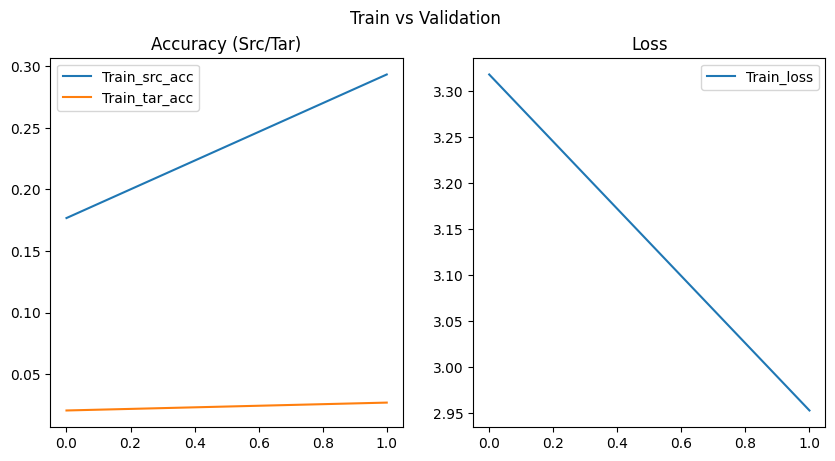

In [ ]:
#@title student
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lambda_coral = 0.8
best_vloss = 1_000_000.
# Computational graph
# import torchviz
# from torchviz import make_dot
#
# reverse_out = make_dot(loss, params=dict(w=w))
# reverse_out.view()
main_teacher_fn = torchvision.models.mobilenet_v3_large(weights='IMAGENET1K_V1').to(device)
main_teacher_fn.classifier[0] = nn.Linear(in_features=960, out_features=1280, bias=True).to(device)
main_teacher_fn.classifier[3] = nn.Linear(in_features=1280, out_features=num_classes, bias=True).to(device)
main_teacher_fn.load_state_dict(torch.load('/content/cp/best_teacher_model.pth'))
# network
student_model = pruned_student_model(1024).to(device)
# summary(student_model, input_size=(channel_size, image_size, image_size))
# Optimizer and cost function
# optimizer = optim.Adam(student_model.parameters(), student_lr,weight_decay=1e-5)
optimizer = torch.optim.SGD(
[dict(params= student_model.features.parameters(), lr=base_lr/10.0), # best at 1e-4
 dict(params= student_model.classifier.parameters()),
  ],
lr=base_lr,  # learning rate for all layers if none of any setting individual
momentum=0.9,weight_decay=5e-4
)

Dl_target = DataLoader(Ds_target, batch_size=batch_size, shuffle=True, num_workers=2)
Dl_source = DataLoader(Ds_source, batch_size=batch_size, shuffle=True, num_workers=2)
scheduler_student = CustomLRScheduler(optimizer, num_epochs_student)
# loss_fn_class = torch.nn.NLLLoss()
# loss_fn_domain = torch.nn.NLLLoss()
loss_fn_class = torch.nn.CrossEntropyLoss()
loss_fn_domain = torch.nn.CrossEntropyLoss()
# Training the same number of batches from both datasets
# max_batches = min(len(Dl_src_training_set_batch), len(Dl_tar_training_set_batch))
max_batches = min(len(Dl_source), len(Dl_target))
# Training
t_0 = time.time()
training_logs_coral = {"train_loss": [],  "train_src_acc": [], "train_tar_acc": []}
for epoch_idx in range(num_epochs_student):
    train_loss, train_src_correct, train_tar_correct = 0, 0, 0
    print(f'epochs {epoch_idx+1:04d} / {num_epochs_student:04d}', end='\n============\n')
    Dl_source_iter = iter(Dl_source)
    Dl_target_iter = iter(Dl_target)
    for batch_idx in range(max_batches):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()
        # Training on source domain
        X_s, y_s = next(Dl_source_iter)
        # Training on target domain
        X_t, y_t = next(Dl_target_iter)
        if X_s.shape[0] != X_t.shape[0]:
          min_bs = min(X_s.shape[0], X_t.shape[0])
          X_s = X_s[:min_bs]
          y_s = y_s[:min_bs]
          X_t = X_t[:min_bs]
          y_t = y_t[:min_bs]
        # y_s = y_s.view(batch_size)
        # y_t = y_t.view(batch_size)
        # GPU processing source and target data
        X_s, y_s = X_s.to(device), y_s.to(device)
        X_t, y_t = X_t.to(device), y_t.to(device)
        class_pred_s = student_model(X_s)
        class_pred_t = student_model(X_t)
        loss_src = loss_fn_class(class_pred_s, y_s)                 # source classification loss
        ################### Regularizer ########################
        # Correlation alignment loss
        loss_coral = CorrelationAlignmentLoss()(class_pred_s, class_pred_t)
        ########################################################
        loss = loss_src + lambda_coral * loss_coral
        if True:
        # No need to update teacher net (freeze teacher weights)
          with torch.no_grad():
              yhat_T = main_teacher_fn(X_t)
          loss_kd = DistillKL(Temperature=2,threshold = 0.6)(class_pred_t, yhat_T)
          loss += 0.9 *loss_kd
        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()
        # #output predict from net
        with torch.no_grad():
          class_prediction_s = student_model(X_s)
          class_prediction_t = student_model(X_t)
        print(f'[{batch_idx+1}/{max_batches}] '
              f'class loss: {loss_src.item():.4f} '
              f'CORAL_loss: {loss_coral.item():.4f} '
              f'KD_loss: {loss_kd.item():.4f} '
              )
        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break
        train_loss += loss.item()
        train_src_correct += (class_prediction_s.argmax(1) == y_s).float().sum().item()
        # print((class_prediction_t.argmax(1) == y_t).float())
        train_tar_correct += (class_prediction_t.argmax(1) == y_t).float().sum().item()
    training_logs_coral["train_loss"].append(train_loss / len(Dl_source))
    training_logs_coral["train_src_acc"].append(train_src_correct / len(Dl_source.dataset))#.dataset))
    training_logs_coral["train_tar_acc"].append(train_tar_correct / len(Dl_target.dataset))#.dataset))
    print(f'Epoch: {epoch_idx+1} || \
    Train_src_acc: {train_src_correct / len(Dl_source.dataset)}, \
    Train_tar_acc: {train_tar_correct / len(Dl_target.dataset)}, \
    Train_loss: {train_loss / len(Dl_source)}'
    )
    scheduler_student.step()
    if train_loss < best_vloss:
      best_vloss = train_loss
      path_save_cp = './cp/'
      if not os.path.exists(path_save_cp):
        os.mkdir(path_save_cp)
      torch.save(student_model.state_dict(), path_save_cp+'best_student_model.pth')
t_end = time.time()-t_0
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end} sec")
plot_graph(training_logs_coral)

#student inference

In [ ]:
# Inference phase


PATH = './cp/best_student_model.pth'
# loaded_model = customhandwrittenmodel().to(device)
loaded_model = pruned_student_model(1024)
loaded_model.to(device)
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()

stored_lbs_tar = torch.empty(0, dtype=torch.float32).to(device)
stored_preds_tar = torch.empty(0, dtype=torch.float32).to(device)
Dl_src_testing_set_batch = torch.utils.data.DataLoader(Dl_src_testing_set, batch_size=64, shuffle=False)
for i, tdata in enumerate(Dl_tar_testing_set_batch):
  with torch.no_grad():
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss


    acc_test += (toutputs.argmax(1) == tlabels).float().sum().item()


    stored_lbs_tar = torch.cat((stored_lbs_tar, tlabels), 0)
    _, prediction_t = torch.max(toutputs, 1)
    stored_preds_tar = torch.cat((stored_preds_tar, prediction_t), 0)


accuracy_t = round(acc_test / float(len(Dl_tar_testing_set_batch.dataset)), 4)
avg_tloss = test_loss / (i + 1)
print('[(pretraining || test loss: {}] [accuracy_test: {} %]\n'.format(avg_tloss, accuracy_t * 100))

Sparsity in f_allpruned[0][0].weight: 14.35%
Sparsity in f_allpruned[1].block[0][0].weight: 9.72%
Sparsity in f_allpruned[1].block[2][0].weight: 19.14%
Sparsity in f_allpruned[2].block[0][0].weight: 21.27%
Sparsity in f_allpruned[2].block[1][0].weight: 15.43%
Sparsity in f_allpruned[2].block[2][0].weight: 23.55%
Sparsity in f_allpruned[3].block[0][0].weight: 36.36%
Sparsity in f_allpruned[3].block[1][0].weight: 33.96%
Sparsity in f_allpruned[3].block[2][0].weight: 30.63%
Sparsity in f_allpruned[4].block[0][0].weight: 18.71%
Sparsity in f_allpruned[4].block[1][0].weight: 33.38%
Sparsity in f_allpruned[4].block[3][0].weight: 11.54%
Sparsity in f_allpruned[5].block[0][0].weight: 19.54%
Sparsity in f_allpruned[5].block[1][0].weight: 62.00%
Sparsity in f_allpruned[5].block[3][0].weight: 21.93%
Sparsity in f_allpruned[6].block[0][0].weight: 19.61%
Sparsity in f_allpruned[6].block[1][0].weight: 52.47%
Sparsity in f_allpruned[6].block[3][0].weight: 18.29%
Sparsity in f_allpruned[7].block[0][0]

<ipython-input-35-4685832a29ee>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH))


[(pretraining || test loss: 3.1719071865081787] [accuracy_test: 11.88 %]



In [ ]:
# Dl_src_training_set_batch = torch.utils.data.DataLoader(Dl_src_training_set, batch_size=64, shuffle=False)
# Dl_tar_training_set_batch = torch.utils.data.DataLoader(Dl_tar_training_set, batch_size=32, shuffle=False)

#function Visualize

In [ ]:
# @title Function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional, List
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm
import os.path as osp
import matplotlib
matplotlib.use('Agg')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as col


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()



"""
  Args: Collect feature
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7
"""

def collect_feature(data_loader: DataLoader, feature_extractor: nn.Module,
                                   device: torch.device, max_num_features=None) -> torch.Tensor:
    """
    Fetch data from `data_loader`, and then use `feature_extractor` to collect features
    Args:
        data_loader (torch.utils.data.DataLoader): Data loader.
        feature_extractor (torch.nn.Module): A feature extractor.
        device (torch.device)
        max_num_features (int): The max number of features to return
    Returns:
        Features in shape (min(len(data_loader), max_num_features), :math:`|\mathcal{F}|`).
    """
    feature_extractor.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
            images = images.to(device)
            features = feature_extractor(images)
            if isinstance(features, tuple):
                # Check if it's a tuple (common when using certain pre-trained models)
                # You may want to select the feature tensor you need from the tuple
                # For example, if the feature tensor is the first element of the tuple:
                feature_tensor = features[0]
                feature_tensor = feature_tensor.to(device)  # Move the tensor to CPU
            else:
                feature_tensor = features.to(device)  # Move the tensor to CPU

            all_features.append(feature_tensor)
            all_labels.append(target)

    return torch.cat(all_features, dim=0),\
        torch.cat(all_labels, dim=0) # Concatenate the list of feature tensors

    #        all_features.append(features)
    #        if max_num_features is not None and i >= max_num_features:
    #            break
    #return torch.cat(all_features, dim=0)


# ref https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7

def visualize(source_feature: torch.Tensor, target_feature: torch.Tensor,
              filename: str, source_color='r', target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    features = np.concatenate([source_feature, target_feature], axis=0)

    # map features to 2-d using TSNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # domain labels, 1 represents source while 0 represents target
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # visualize using matplotlib
    plt.figure(figsize=(10, 10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=domains, cmap=col.ListedColormap([source_color, target_color]), s=20)  #default: s=2
    plt.savefig(filename)


"""
  Arg: t-SNE for class clustering visualization
"""

def visualize_class_n_domain(source_feature: torch.Tensor,
                             target_feature: torch.Tensor,
                             source_labels: torch.Tensor,
                             target_labels: torch.Tensor,
                             filename: str,
                             source_color='r',
                             target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        source_labels (tensor): class labels for source domain features
        target_labels (tensor): class labels for target domain features
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    source_labels = source_labels.cpu().numpy()
    target_labels = target_labels.cpu().numpy()

    # Combine features and labels
    features = np.concatenate([source_feature, target_feature], axis=0)
    labels = np.concatenate([source_labels, target_labels], axis=0)
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # Map features to 2-D using t-SNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # Visualize using matplotlib
    plt.figure(figsize=(10, 10))

    # Get unique class labels
    unique_labels = np.unique(labels)

    # Create a color map for classes
    #cmap = plt.get_cmap('tab20', len(unique_labels))
    cmap_s = plt.get_cmap('nipy_spectral', len(unique_labels))
    cmap_r = plt.get_cmap('gist_rainbow', len(unique_labels))

    # Plot data points for each class and domain
    for label in unique_labels:
        for domain in [0, 1]:
            mask = (labels == label) & (domains == domain)
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,
                        #label=f"Class {label}, Domain {domain}",
                        )

    plt.legend()
    plt.savefig(filename)

# Example usage
# visualize(source_feature, target_feature, source_labels, target_labels, 'tsne_plot.png')





from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD

"""
  Args: A-distance computation
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/a_distance.py
"""

def binary_accuracy(output: torch.Tensor, target: torch.Tensor) -> float:
    """Computes the accuracy for binary classification"""
    with torch.no_grad():
        batch_size = target.size(0)
        pred = (output >= 0.5).float().t().view(-1)
        correct = pred.eq(target.view(-1)).float().sum()
        correct.mul_(100. / batch_size)
        return correct

class ANet(nn.Module):
    def __init__(self, in_feature):
        super(ANet, self).__init__()
        self.layer = nn.Linear(in_feature, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer(x)
        x = self.sigmoid(x)
        return x


def Adist_calculate(source_feature: torch.Tensor, target_feature: torch.Tensor,
              device, progress=True, training_epochs=10):
    """
    Calculate the :math:`\mathcal{A}`-distance, which is a measure for distribution discrepancy.
    The definition is :math:`dist_\mathcal{A} = 2 (1-2\epsilon)`, where :math:`\epsilon` is the
    test error of a classifier trained to discriminate the source from the target.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        device (torch.device)
        progress (bool): if True, displays a the progress of training A-Net
        training_epochs (int): the number of epochs when training the classifier
    Returns:
        :math:`\mathcal{A}`-distance
    """
    source_label = torch.ones((source_feature.shape[0], 1))
    target_label = torch.zeros((target_feature.shape[0], 1))
    feature = torch.cat([source_feature, target_feature], dim=0)
    label = torch.cat([source_label, target_label], dim=0)

    dataset = TensorDataset(feature, label)
    length = len(dataset)
    train_size = int(0.8 * length)
    val_size = length - train_size

    # Specify a random generator for CUDA
    # Use CPU for the random split generator
    generator = torch.Generator(device='cpu')

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size], generator=generator)
    train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

    # Continue using CUDA for model training
    anet = ANet(feature.shape[1]).to(device)
    optimizer = SGD(anet.parameters(), lr=0.01)
    a_distance = 2.0

    for epoch in range(training_epochs):
        anet.train()
        for (x, label) in train_loader:
            x = x.to(device)
            label = label.to(device)
            anet.zero_grad()
            y = anet(x)
            loss = F.binary_cross_entropy(y, label)
            loss.backward()
            optimizer.step()

        anet.eval()
        meter = AverageMeter("accuracy", ":4.2f")
        with torch.no_grad():
            for (x, label) in val_loader:
                x = x.to(device)
                label = label.to(device)
                y = anet(x)
                acc = binary_accuracy(y, label)
                meter.update(acc, x.shape[0])
        error = 1 - meter.avg / 100
        a_distance = 2 * (1 - 2 * error)
        if progress:
            print("epoch {} accuracy: {} A-dist: {}".format(epoch, meter.avg, a_distance))

    return a_distance





class AverageMeter(object):
    r"""Computes and stores the average and current value.
    Examples::
        >>> # Initialize a meter to record loss
        >>> losses = AverageMeter()
        >>> # Update meter after every minibatch update
        >>> losses.update(loss_value, batch_size)
    """
    def __init__(self, name: str, fmt: Optional[str] = ':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        if self.count > 0:
            self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class AverageMeterDict(object):
    def __init__(self, names: List, fmt: Optional[str] = ':f'):
        self.dict = {
            name: AverageMeter(name, fmt) for name in names
        }

    def reset(self):
        for meter in self.dict.values():
            meter.reset()

    def update(self, accuracies, n=1):
        for name, acc in accuracies.items():
            self.dict[name].update(acc, n)

    def average(self):
        return {
            name: meter.avg for name, meter in self.dict.items()
        }

    def __getitem__(self, item):
        return self.dict[item]


class Meter(object):
    """Computes and stores the current value."""
    def __init__(self, name: str, fmt: Optional[str] = ':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0

    def update(self, val):
        self.val = val

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '}'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [ ]:
###########################################################################################
# --- Confusion matrix, F1-score, precision, recall, NMI/RI scores
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(31)
# lb_classes = ('back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair' ,'desk_lamp', 'desktop_computer', 'file_cabinet','headphones','keyboard','laptop_computer','letter_tray','mobile_phone','monitor','mouse','mug','paper_notebook','pen','phone','printer','projector','punchers','ring_binder','ruler','scissors','speaker','stapler','tape_dispenser','trash_can')
lb_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30')


lb = stored_lbs_tar.cpu()
prd = stored_preds_tar.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")


source_feature, s_labels = collect_feature(Dl_src_training_set_batch, loaded_model, device)
target_feature, t_labels = collect_feature(Dl_tar_training_set_batch, loaded_model, device)

# --- Calculate A-distance, which is a measure for distribution discrepancy
A_distance = Adist_calculate(source_feature, target_feature, device)
print("A-distance =", A_distance)

# --- plot t-SNE
if not os.path.exists('./output/'): os.mkdir('./output/')
tSNE_filename = osp.join('./output/', 'W5-3_tSNE.png')
visualize_class_n_domain(source_feature, target_feature, s_labels, t_labels, tSNE_filename)    # two-domain multi-class rep
visualize(source_feature, target_feature,'./output/yay.png')
print("Saving t-SNE to", tSNE_filename)

Precision/Recall/F-beta score: (0.07693596464584973, 0.11879432624113476, 0.05749868134079006, None)
NMI score: 0.2878653693880609, RI score: 0.05420147302859045


100%|██████████| 71/71 [00:07<00:00, 10.06it/s]


epoch 0 accuracy: 82.48587036132812 A-dist: 1.2994346618652344
epoch 1 accuracy: 82.48587036132812 A-dist: 1.2994346618652344
epoch 2 accuracy: 82.48587036132812 A-dist: 1.2994346618652344
epoch 3 accuracy: 82.48587036132812 A-dist: 1.2994346618652344
epoch 4 accuracy: 82.48587036132812 A-dist: 1.2994346618652344
epoch 5 accuracy: 82.48587036132812 A-dist: 1.2994346618652344
epoch 6 accuracy: 82.48587036132812 A-dist: 1.2994346618652344
epoch 7 accuracy: 82.48587036132812 A-dist: 1.2994346618652344
epoch 8 accuracy: 82.48587036132812 A-dist: 1.2994346618652344
epoch 9 accuracy: 82.48587036132812 A-dist: 1.2994346618652344
A-distance = tensor(1.2994, device='cuda:0')


<ipython-input-37-6ae620c5f277>:221: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,


Saving t-SNE to ./output/W5-3_tSNE.png


In [ ]:
import os
from glob import glob
from pathlib import Path
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
# Create evaluation function for the model
def evaluate(val_dir, model, device):
    # Move model to the appropriate device (CPU or GPU)
    model.to(device)
    model.eval()  # Set the model to evaluation mode (important for models with dropout or batch normalization)

    paths = glob(os.path.join(val_dir, "*", "*"))  # Get all image paths in the validation directory
    predictions = []  # List to store prediction results

    #---create a dictionary mapping folder names to numerical labels---
    labels = {'back_pack': 0, 'bike': 1, 'bike_helmet': 2, 'bookcase': 3, 'bottle': 4, 'calculator': 5, 'desk_chair': 6,
          'desk_lamp': 7, 'desktop_computer': 8, 'file_cabinet': 9,'headphones': 10,'keyboard': 11,'laptop_computer': 12,
          'letter_tray': 13,'mobile_phone': 14,'monitor': 15,'mouse': 16,'mug': 17,'paper_notebook': 18,'pen': 19,
          'phone': 20,'printer': 21,'projector': 22,'punchers': 23,'ring_binder': 24,'ruler': 25,'scissors': 26,
          'speaker': 27,'stapler': 28,'tape_dispenser': 29,'trash_can': 30}

        # Define the image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),          # Resize the image
        transforms.ToTensor(),            # Convert the image to a PyTorch tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the image
    ])

    for idx, path in enumerate(paths):
        # Load and transform the image
        img = Image.open(path).convert('RGB')  # Convert the image to RGB
        img = transform(img).unsqueeze(0).to(device)  # Apply transformations and add batch dimension

        # Disable gradient calculation for inference
        with torch.no_grad():
            pred = model(img)

        # Store the prediction and the true label (from folder name)
        predictions.append({
            "path": path,
            "prediction": int(pred.argmax(dim=1).item()),  # Get predicted class
            #---get label from dictionary---
            "label": labels[Path(path).parent.name]  # Get the true label from the folder name
        })

    # Convert predictions to a DataFrame for easier manipulation
    results = pd.DataFrame(predictions)

    # Calculate and print accuracy
    accuracy = (results.prediction == results.label).sum() / len(results)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return results

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pred_df = evaluate(f'./Office-31/{TARGET_DOMAIN}/', loaded_model, device)
pred_df.head(10)

Accuracy: 14.41%


,path,prediction,label
0,./Office-31/amazon/bookcase/frame_0018.jpg,15,3
1,./Office-31/amazon/bookcase/frame_0061.jpg,12,3
2,./Office-31/amazon/bookcase/frame_0005.jpg,15,3
3,./Office-31/amazon/bookcase/frame_0019.jpg,1,3
4,./Office-31/amazon/bookcase/frame_0065.jpg,14,3
5,./Office-31/amazon/bookcase/frame_0006.jpg,2,3
6,./Office-31/amazon/bookcase/frame_0049.jpg,27,3
7,./Office-31/amazon/bookcase/frame_0069.jpg,15,3
8,./Office-31/amazon/bookcase/frame_0082.jpg,27,3
9,./Office-31/amazon/bookcase/frame_0053.jpg,15,3


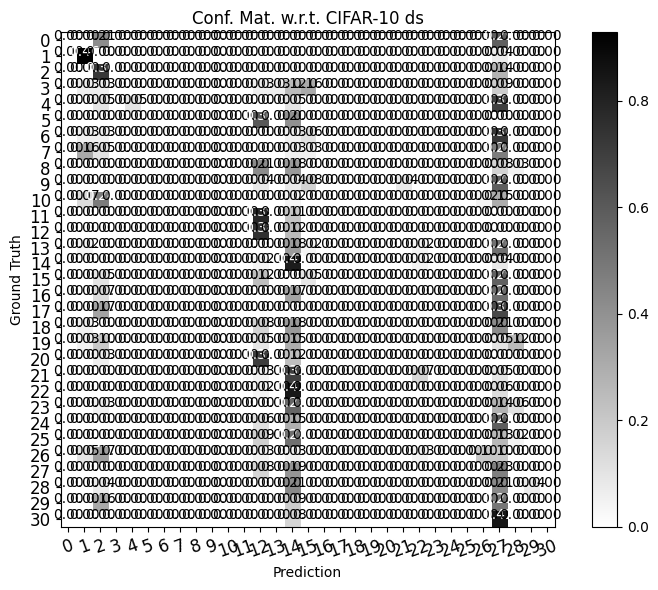

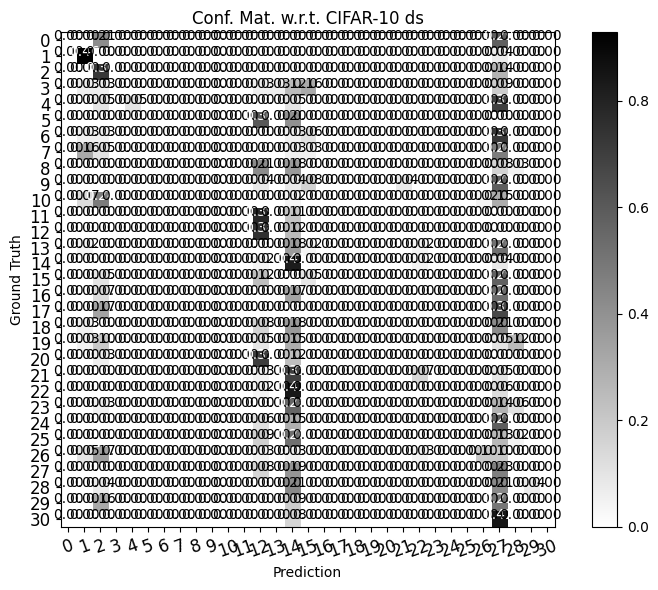

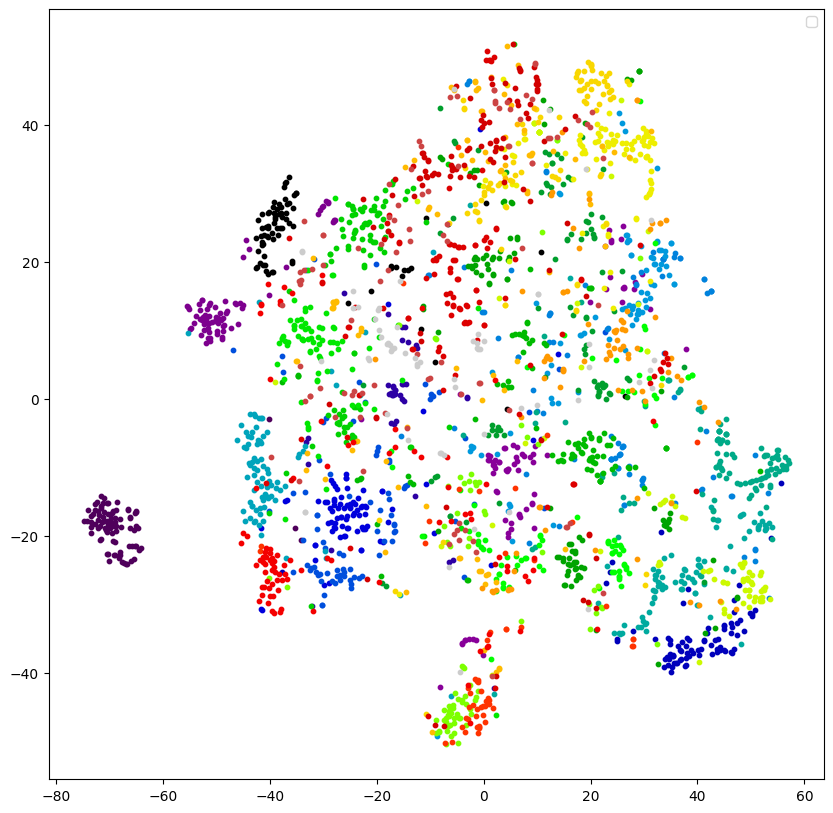

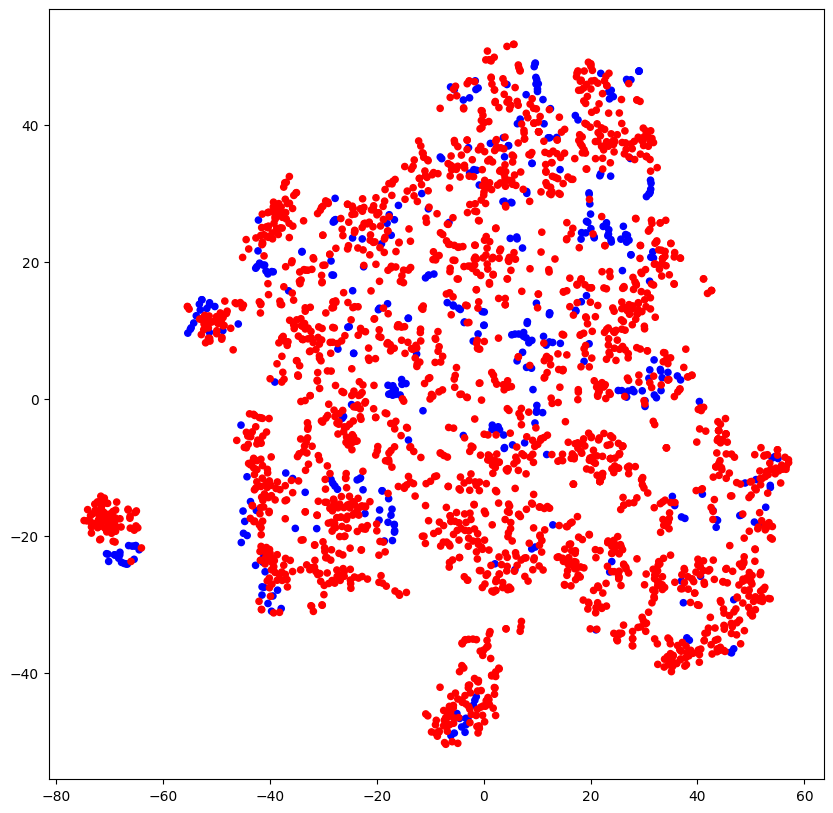

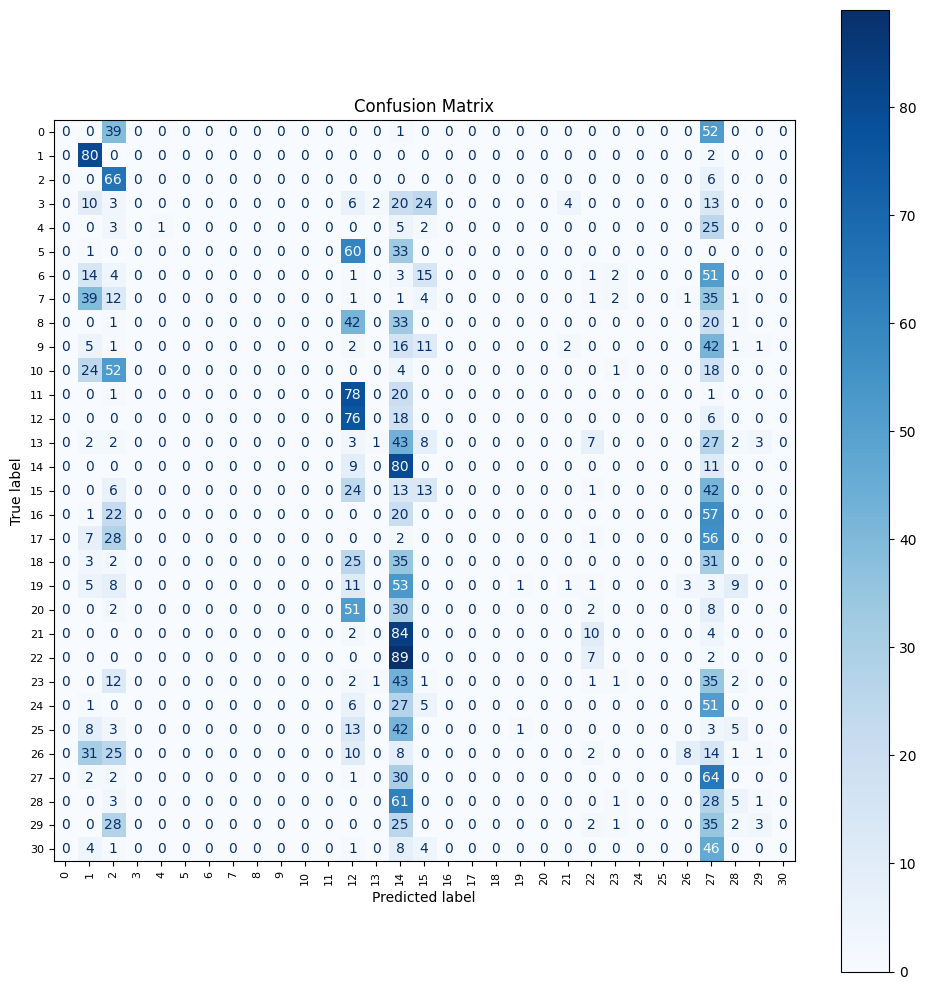

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion matrix
cm = confusion_matrix(pred_df['label'], pred_df['prediction'], labels=range(31))

# Increase figure size and adjust font size
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(31))
display.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')

# Adjust font sizes
plt.xticks(fontsize=8)  # Smaller x-axis labels
plt.yticks(fontsize=8)  # Smaller y-axis labels
plt.title('Confusion Matrix', fontsize=12)  # Adjust title font size
plt.tight_layout()  # Adjust the layout so everything fits

plt.show()


#ONNX

In [ ]:
!pip install onnx
!pip install onnxscript

In [ ]:
for name, module in loaded_model.named_modules():
    if isinstance(module, nn.Conv2d):
        print(f"{name} has attributes: {dir(module)}")
        if hasattr(module, 'weight_orig') and hasattr(module, 'weight_mask'):
            print(f"{name} is pruned with weights and mask")
        else:
            print(f"{name} is not pruned or pruning was not applied correctly")
loaded_model.to('cpu')
torch_input = torch.randn(1, 3, 224, 224).to('cpu')
onnx_program = torch.onnx.export(
    loaded_model.eval(),           # The pruned model
    torch_input,                     # Example input tensor
    "my_image_classifier.onnx",      # Path to save the ONNX model
    opset_version=11,                # Set ONNX opset version (adjust as needed)
    input_names=['input'],           # Input names
    output_names=['output'],         # Output names
)

features.0.0 has attributes: ['T_destination', '__annotations__', '__call__', '__class__', '__constants__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_conv_forward', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.HalfTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
import onnx
onnx_model = onnx.load("my_image_classifier.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
# Execute the ONNX model with ONNX Runtime
# !pip install onnxruntime
!pip install onnxruntime-gpu
import onnxruntime


ort_session = onnxruntime.InferenceSession("./my_image_classifier.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
    return tensor

onnx_input = to_numpy(torch_input)  # Convert torch input to NumPy

# Prepare the ONNX Runtime input dictionary
onnxruntime_input = {ort_session.get_inputs()[0].name: onnx_input}

# Run inference using ONNX Runtime
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)

# Run the PyTorch model to get outputs for comparison
# onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}
# onnxruntime_outputs = ort_session.run(None, onnxruntime_input)


# Compare the PyTorch results with the ones from the ONNX Runtime
torch_outputs = loaded_model(torch_input)

torch_outputs_numpy = to_numpy(torch_outputs)
assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnxruntime_output in zip(torch_outputs, onnxruntime_outputs):
    onnxruntime_output = np.squeeze(onnxruntime_output)
    torch.testing.assert_close(torch_output, torch.tensor(onnxruntime_output))

print("\n\nPyTorch and ONNX Runtime output matched!")
print(f"\n\nPyTorch Input length: {len(torch_output)}")
print(f"PyTorch Sample Input: {torch_output}")
print(f"\n\nONNXRuntime Output length: {len(onnxruntime_outputs)}")
print(f"ONNXRuntime Sample output: {onnxruntime_outputs}")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.HalfTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
input_shape = (1, 3, 224, 224)
input_data_for_inference = torch.randn(input_shape, dtype=torch.float32).cuda()
input_data_for_inference_fp16 = input_data_for_inference.to(dtype=torch.float16)

In [ ]:
import time
input_shape = (1, 3, 224, 224)
output_shape = (1, 576)

##FP32

In [ ]:
#@title Non-optimized
#>>>> batch runs session
print("Non-optimizing FP32 bench testing...")
#---Non-optimized---
nonopt_model = loaded_model.cuda().eval()
num_iterations = 10
total_time = 0.0
with torch.no_grad():
    for i in range(num_iterations):
        start_time = time.time()
        input_data = torch.randn(input_shape).cuda()
        output_data = nonopt_model(input_data)
        end_time = time.time()
        total_time += end_time - start_time
pytorch_fps = num_iterations / total_time
print(f"PyTorch FPS: {pytorch_fps:.2f}")



#---------Inference with FP32--------------
import onnxruntime as ort
# Load the ONNX model and run inference
# session = ort.InferenceSession('my_image_classifier_fp16.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
# onnx_input = onnx_program.adapt_torch_inputs_to_onnx(torch_input)
# onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

output_data = nonopt_model(input_data_for_inference)

print(f"\n\nONNXRuntime [FP32] Output length: {len(output_data)}")
print(f"ONNXRuntime [FP32] Sample output: {output_data}")
print(f"ONNXRuntime [FP32] Sample output type: {output_data.dtype}")

Non-optimizing FP32 bench testing...


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same

In [ ]:
#@title Optimized
import os
os.environ["ALLOW_RELEASED_ONNX_OPSET_ONLY"] = "0"
import onnxruntime.backend as backend

print("Optimized model FP32 bench testing...")
# Create a engine from the ONNX model and measure inference speed
model_onnx = onnx.load('./my_image_classifier.onnx')
onnx_engine = backend.prepare(model_onnx, device='GPU')
num_iterations = 10
total_time_fp32 = 0.0
print("start inferencing...FP32")
with torch.no_grad():
    for i in range(num_iterations):
        input_data = torch.randn(input_shape).cuda()
        start_time = time.time()
        output_data = onnx_engine.run(input_data.cpu().numpy())[0]
        end_time = time.time()
        total_time_fp32 += end_time - start_time
tensor_fps_fp32 = num_iterations /total_time_fp32
#tensor_fps = num_iterations / total_time
print(f"Tensor FPS [FP32]: {tensor_fps_fp32:.2f}")
print(f"Speedup: {tensor_fps_fp32/pytorch_fps:.2f}x")


#---------Inference with FP16--------------
import onnxruntime as ort
# Load the ONNX model and run inference
# session = ort.InferenceSession('my_image_classifier_fp16.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
# onnx_input = onnx_program.adapt_torch_inputs_to_onnx(torch_input)
# onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

output_data = onnx_engine.run(input_data_for_inference.cpu().numpy())[0]

print(f"\n\nONNXRuntime [FP32] Output length: {len(output_data)}")
print(f"ONNXRuntime [FP32] Sample output: {output_data}")
print(f"ONNXRuntime [FP32] Sample output type: {output_data.dtype}")

##FP16

In [ ]:


# @title Optimized FP16 (Half Tensor)
print("Optimized model FP16 bench testing...")

# Try using CUDAExecutionProvider and check if it's available
# ort_session = onnxruntime.InferenceSession("./my_image_classifier.onnx", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

torch_model_fp16 = loaded_model.to('cpu').half()
dummy_input_fp16 = torch.randn(input_shape, dtype=torch.float16)
input_names = ['input']
output_names = ['output']
torch.onnx.export(torch_model_fp16, dummy_input_fp16, './my_image_classifier_fp16.onnx', verbose=False, input_names=input_names, output_names=output_names)

#onnx_model_path_fp16 = f'outputs/{opt["compressed_directory"]}/compressed_student_net_fp16.onnx'
#session_fp16 = ort.InferenceSession(onnx_model_path_fp16, providers=providers)

# Create a engine from the ONNX model and measure inference speed
model_onnx_fp16 = onnx.load('./my_image_classifier_fp16.onnx')
onnx_engine_fp16 = backend.prepare(model_onnx_fp16, device='GPU', provider='CUDAExecutionProvider', float16=True)

num_iterations = 10
total_time_fp16 = 0.0
print("start inferencing...FP16")
with torch.no_grad():
    for i in range(num_iterations):
        input_data = torch.randn(input_shape, dtype=torch.float16).cuda()
        start_time = time.time()
        output_data = onnx_engine_fp16.run(input_data.cpu().numpy())[0]
        end_time = time.time()
        total_time_fp16 += end_time - start_time
tensor_fps_fp16 = num_iterations /total_time_fp16
#tensor_fps = num_iterations / total_time
print(f"Tensor FPS [FP16]: {tensor_fps_fp16:.2f}")
print(f"Speedup: {tensor_fps_fp16/pytorch_fps:.2f}x")





#---------Inference with FP16--------------
import onnxruntime as ort
# Load the ONNX model and run inference
# session = ort.InferenceSession('my_image_classifier_fp16.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
# onnx_input = onnx_program.adapt_torch_inputs_to_onnx(torch_input)
# onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}
# input_data = torch.randn(input_shape, dtype=torch.float16).cuda()
output_data = onnx_engine_fp16.run(input_data_for_inference_fp16.cpu().numpy())[0]

print(f"\n\nONNXRuntime [FP16] Output length: {len(output_data)}")
print(f"ONNXRuntime [FP16] Sample output: {output_data}")
print(f"ONNXRuntime [FP16] Sample output type: {output_data.dtype}")

## INT8

In [ ]:
!pip install onnx onnxruntime onnxruntime-tools


import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

# Load your pruned ONNX model
model_path = "path_to_your_model.onnx"
quantized_model_path = "path_to_quantized_model.onnx"

# Perform dynamic quantization
quantize_dynamic(model_input=model_path,
                 model_output=quantized_model_path,
                 weight_type=QuantType.QInt8)  # You can also use QuantType.QUInt8


import onnx

# Load and check the quantized model
quantized_model = onnx.load(quantized_model_path)
onnx.checker.check_model(quantized_model)
print("The model was successfully quantized.")


#static Qunatized INT8

In [ ]:
import torch
import torchvision.models as models
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

# 1. Load a pre-trained ResNet18 model
model = loaded_model.to('cpu')

model.eval()

# 2. Specify the quantization configuration (e.g., fbgemm for x86 CPUs)
model.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')

# 3. Prepare the example input (required for tracing the model)
example_inputs = torch.randn(1, 3, 224, 224).to

# 4. Prepare the model for static quantization (requires example input)
prepared_model = prepare_fx(model, {'': torch.ao.quantization.default_qconfig}, example_inputs=(example_inputs,))

# 5. Calibrate the model with representative data (run inference to collect statistics)
for _ in range(100):  # Use real data for calibration in practice
    prepared_model(torch.randn(1, 3, 224, 224).to('cpu'))

# 6. Convert the prepared model to a quantized version
quantized_model = convert_fx(prepared_model)

# 7. Check the quantized model structure
print(quantized_model)

# 8. Export the quantized model to ONNX for deployment
quantized_onnx_model_path = "resnet18_quantized_static.onnx"
torch.onnx.export(quantized_model, example_inputs, quantized_onnx_model_path,
                  opset_version=13, input_names=['input'], output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

print(f"Quantized ONNX model saved to {quantized_onnx_model_path}")







In [ ]:
import onnxruntime as ort
import numpy as np

# 1. Load the ONNX model
onnx_model_path = "resnet18_quantized_static.onnx"
ort_session = ort.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])

# 2. Print session information
print(f"ONNX model loaded. Input Names: {ort_session.get_inputs()[0].name}")
print(f"Input Shape: {ort_session.get_inputs()[0].shape}")
print(f"Input Type: {ort_session.get_inputs()[0].type}")

# 3. Prepare a random test input (for an RGB image of size 224x224, batch size 1)
test_input = np.random.randn(1, 3, 224, 224).astype(np.float32)

# 4. Run inference
outputs = ort_session.run(None, {ort_session.get_inputs()[0].name: test_input})

# 5. Print the output
print("Inference output:", outputs)

In [ ]:
# Create a engine from the ONNX model and measure inference speed
# model_onnx_int8 = onnx.load('./resnet18_quantized_static.onnx')
# onnx_engine_int8 = backend.prepare(model_onnx_int8, device='CPU', provider='CPUExecutionProvider', float16=True)

onnx_model_path = "resnet18_quantized_static.onnx"
ort_session = ort.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])



# Run a calibration step to collect statistics
num_iterations = 100000
total_time_int8 = 0.0
with torch.no_grad():
    for i in range(num_iterations):
        input_data = torch.randn(input_shape, dtype=torch.float32).cuda()
        start_time = time.time()
        output_data = ort_session.run(None, {ort_session.get_inputs()[0].name: input_data.cpu().numpy()})[0]

        end_time = time.time()
        total_time_int8 += end_time - start_time
tensor_fps_int8 = num_iterations /total_time_int8
#tensor_fps = num_iterations / total_time
print(f"Tensor FPS [INT8]: {tensor_fps_int8:.2f}")
print(f"Speedup: {tensor_fps_int8/pytorch_fps:.2f}x")

#---------Inference with INT8--------------
import onnxruntime as ort
# Load the ONNX model

# Load the ONNX model and run inference
# session = ort.InferenceSession('my_quantized_classifier_int8.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
# input_data = torch.randn(input_shape, dtype=torch.float32).cpu().numpy()
# output_quan_oxrun = session.run(None, {'l_x_': onnxruntime_input})[0]
# onnx_input = onnx_program.adapt_torch_inputs_to_onnx(torch_input)
# onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}
# output_quan_oxrun = session.run(None, onnxruntime_input)

# input_data = torch.randn(input_shape, dtype=torch.float32).cuda()


output_quan_oxrun = ort_session.run(None, {ort_session.get_inputs()[0].name: input_data_for_inference.cpu().numpy()})[0]

print(f"\n\nONNXRuntime [INT8] Output length: {len(output_quan_oxrun)}")
print(f"ONNXRuntime [INT8] Sample output: {output_quan_oxrun}")
print(f"ONNXRuntime [INT8] Sample output type: {output_quan_oxrun.dtype}")

In [ ]:
import torch
import torch.quantization

import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType


# Apply dynamic quantization to INT8
model_int8 = quantize_dynamic(
    'my_image_classifier.onnx',
    'my_quantized_classifier_int8.onnx',
    weight_type=QuantType.QInt8  # You can use QuantType.QUInt8 for unsigned INT8
)
#---------------------------------------------------------


model_onnx_int8 = onnx.load('./my_quantized_classifier_int8.onnx')
onnx_engine_int8 = backend.prepare(model_onnx_int8, device='CPU', provider='CUDAExecutionProvider', float16=True)


num_iterations = 10000
total_time_int8 = 0.0
with torch.no_grad():
    for i in range(num_iterations):
        input_data = torch.randn(input_shape, dtype=torch.float32).cuda()
        start_time = time.time()
        output_data = onnx_engine_int8.run(input_data.cpu().numpy())[0]
        end_time = time.time()
        total_time_int8 += end_time - start_time
tensor_fps_int8 = num_iterations /total_time_int8
#tensor_fps = num_iterations / total_time
print(f"Tensor FPS [INT8]: {tensor_fps_int8:.2f}")
print(f"Speedup: {tensor_fps_int8/pytorch_fps:.2f}x")

#---------Inference with INT8--------------
import onnxruntime as ort
# Load the ONNX model

# Load the ONNX model and run inference
# session = ort.InferenceSession('my_quantized_classifier_int8.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
# input_data = torch.randn(input_shape, dtype=torch.float32).cpu().numpy()
# output_quan_oxrun = session.run(None, {'l_x_': onnxruntime_input})[0]
# onnx_input = onnx_program.adapt_torch_inputs_to_onnx(torch_input)
# onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}
# output_quan_oxrun = session.run(None, onnxruntime_input)

# input_data = torch.randn(input_shape, dtype=torch.float32).cuda()
output_quan_oxrun = onnx_engine_int8.run(input_data_for_inference.cpu().numpy())[0]

print(f"\n\nONNXRuntime [INT8] Output length: {len(output_quan_oxrun)}")
print(f"ONNXRuntime [INT8] Sample output: {output_quan_oxrun}")
print(f"ONNXRuntime [INT8] Sample output type: {output_quan_oxrun.dtype}")

